In [140]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))
sampleSubmission <- read.csv(file.path("..", "data", "sampleSubmission.csv"))

In [141]:
#delets dependent variables
train.dub <- train.data[!duplicated(as.list(train.data))]


In [143]:
library(tidymodels)
library(leaps)

#data set with VALENCE.PLEASANTNESS + V.. (with low varinace)
length <- length(train.dub[1,])
idx.low.var <- apply(train.dub[,4:length], 2, var) < 0.24 # identify pixels with low variance 
V.data <- data.frame(train.dub[,4:length])
V.data <- data.frame(V.data[,!idx.low.var])
V.data$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS


V.data.x = data.frame(train.dub[,4:length])
V.data.y = V.data$VALENCE.PLEASANTNESS

In [144]:
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}

In [146]:
#Forward selection with K-fold Cross Validation 
nvmax = 50
validation_data <- vfold_cv(V.data, v = 5)

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), nvmax = nvmax, method = 'forward')
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict.regsubsets(fit, valid.set, id, formula))^2))
}
           
cv.errors <- sapply(validation_data$splits, fit_and_evaluate)
rowMeans(cv.errors)
          

[1] 523.6617 527.7024 529.6903 527.7228 525.7566 526.3832 532.7434 539.9285
 [9] 534.9122 536.7686 542.0340 549.5605 554.0642 558.1813 557.2954 561.7867
[17] 561.0165 559.7987 557.8517 558.1593 557.5348 553.0905 554.5008 557.1623
[25] 555.4542 559.3762 561.1744 557.3199 555.6207 555.3756 555.1461 563.9607
[33] 561.5738 561.9415 561.6637 562.4600 561.8205 563.2309 562.2386 560.4140
[41] 560.6597 559.9926 558.0574 556.5619 554.7394 557.2987 558.5728 556.2575
[49] 556.6154 558.6212

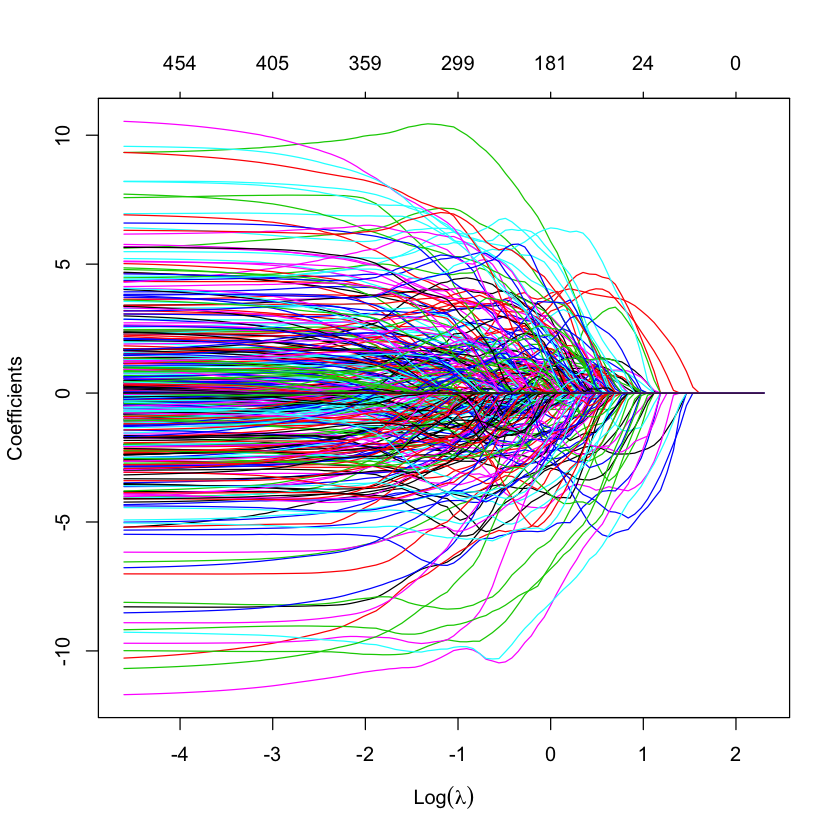

In [147]:
#Lasso regularization 
library(glmnet)
V.data.y = as.matrix(V.data.y)
V.data.x = as.matrix(V.data.x)
lasso.mod <- glmnet(V.data.x,V.data.y, alpha = 1, lambda = 10^seq(1, -2, length = 100))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

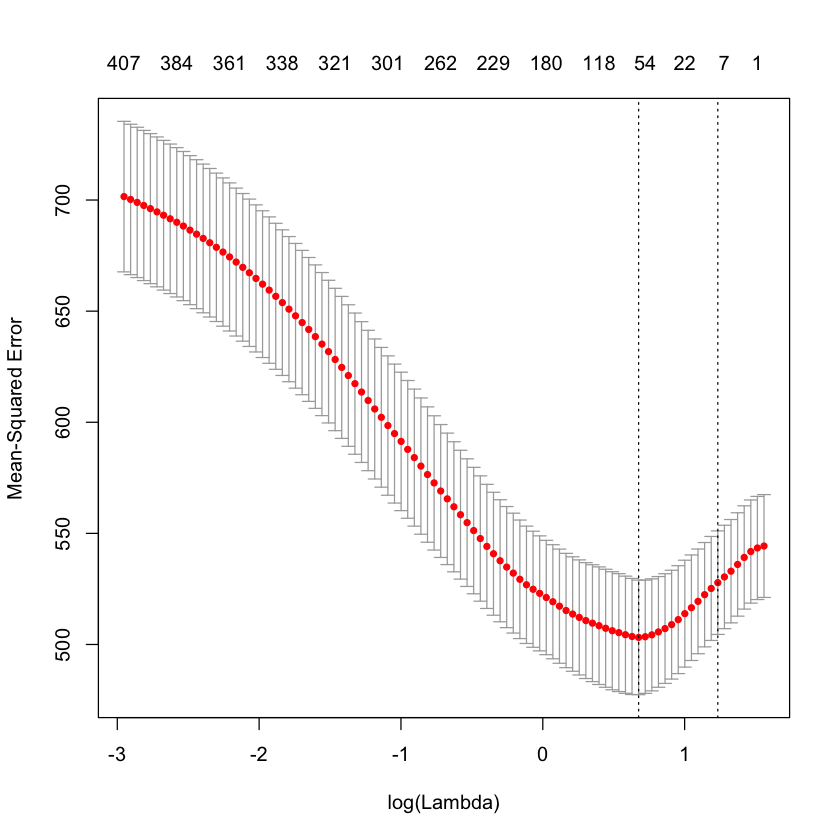

In [148]:
cv.lasso <- cv.glmnet(V.data.x, V.data.y, alpha = 1, nfold = 10)
plot(cv.lasso)

In [149]:
best.lasso <- glmnet(V.data.x, V.data.y, alpha = 1, lambda = cv.lasso$lambda.min)
myCoefs = coef(best.lasso)
NonZeroCoeffs = myCoefs[which(myCoefs != 0 )]
CoeffNames = myCoefs@Dimnames[[1]][which(myCoefs != 0 ) ]
myResults <- data.frame(
  features = myCoefs@Dimnames[[1]][ which(myCoefs != 0 ) ], #intercept included
  coefs    = myCoefs              [ which(myCoefs != 0 ) ]  #intercept included
)
dim(myResults)
myResults


[1] 62  2

features,coefs
(Intercept),41.61151820
V212,0.50987834
V256,3.70108334
V492,-0.18136615
V534,1.28199217
V546,0.03621712
V825,0.80132424
V858,3.74534611
V1141,0.87879714
V1634,0.54719105
